In [151]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings('ignore')

Goal: predict monthly demand based on weather features and number of electricity-powered vehicles

**Load data**

In [167]:
# CA monthly vehicle distribution
# Electricity-powered vehicles only

df = pd.read_csv('data/cleaned/monthly_vehicles.csv')
df = df[['date','electric','plug-in hybrid electric']]

df.head()

,date,electric,plug-in hybrid electric
0,202112,522445,305315
1,202111,505951,300973
2,202110,490400,297256
3,202109,476248,292462
4,202108,462251,289169


In [168]:
# CA monthly demand

df2 = pd.read_csv('data/cleaned/monthly_demand.csv')
df2 = df2.rename(columns={'Unnamed: 0':'date'})

df2.head()

,date,demand
0,202211,18098856
1,202210,22583054
2,202209,27240453
3,202208,29002852
4,202207,26935101


In [169]:
# Monthly maximum temperature in each CA county (degrees Fahrenheit)

df3 = pd.read_csv('data/cleaned/monthly_tmax.csv')
df3 = df3.drop(columns=['Unnamed: 0'])

df3.head()

,date,county 1 tmax,county 3 tmax,county 5 tmax,county 7 tmax,county 9 tmax,county 11 tmax,county 13 tmax,county 15 tmax,county 17 tmax,...,county 101 tmax,county 103 tmax,county 105 tmax,county 107 tmax,county 109 tmax,county 111 tmax,county 113 tmax,county 115 tmax,mean tmax,date_idx
0,201501,61.0,48.5,59.9,61.0,60.2,61.9,60.1,54.7,57.2,...,60.6,61.0,54.5,53.1,54.4,64.1,61.2,61.4,59.558621,1
1,201502,65.4,50.9,63.7,65.3,64.8,67.3,66.1,55.9,59.4,...,67.8,63.5,57.6,60.8,57.4,66.4,67.3,66.3,64.100000,2
2,201503,70.8,53.5,69.3,71.3,70.0,74.6,72.2,60.7,63.8,...,76.1,69.1,64.1,65.5,60.7,71.4,74.5,72.5,69.410345,3
3,201504,69.6,52.2,68.4,72.2,69.3,76.2,71.6,60.9,63.1,...,78.1,70.8,64.9,65.1,59.6,68.6,76.8,73.3,69.055172,4
4,201505,68.8,55.9,72.7,76.8,73.2,80.0,71.1,67.3,67.5,...,81.5,75.4,71.7,67.9,62.3,68.7,79.4,77.7,71.446552,5


In [170]:
# Monthly average precipitation in each CA county (inches)

df4 = pd.read_csv('data/cleaned/monthly_precip.csv')
df4 = df4.drop(columns=['Unnamed: 0'])

df4.head()

,date,county 1 precip,county 3 precip,county 5 precip,county 7 precip,county 9 precip,county 11 precip,county 13 precip,county 15 precip,county 17 precip,...,county 101 precip,county 103 precip,county 105 precip,county 107 precip,county 109 precip,county 111 precip,county 113 precip,county 115 precip,mean precip,date_idx
0,201501,0.01,0.22,0.14,0.21,0.13,0.18,0.01,3.49,0.12,...,0.10,0.25,1.79,0.47,0.14,1.97,0.06,0.08,0.440345,1
1,201502,2.25,5.53,5.36,4.58,5.26,3.66,2.34,11.17,6.96,...,2.49,4.29,11.74,2.29,5.12,0.88,3.20,4.42,3.597241,2
2,201503,0.26,0.62,0.83,0.58,0.64,0.54,0.26,5.65,0.87,...,0.17,1.04,2.53,0.43,0.68,0.69,0.17,0.48,0.722759,3
3,201504,1.15,2.52,3.09,2.24,2.64,1.78,1.09,4.36,3.41,...,1.52,1.76,2.03,0.87,3.29,0.32,1.31,2.75,1.556897,4
4,201505,0.37,2.99,1.39,0.29,1.18,0.08,0.20,0.68,1.96,...,0.03,0.61,1.23,1.76,2.70,0.61,0.10,0.17,0.862759,5


In [171]:
df = df.merge(df2)

df = df.merge(df3[['date','mean tmax']], left_on='date', right_on='date') # Only use mean max temperature for whole state

df = df.merge(df4[['date','mean precip']], left_on='date', right_on='date') # Only use mean precip for whole state

df.head()

,date,electric,plug-in hybrid electric,demand,mean tmax,mean precip
0,202112,522445,305315,22418337,51.368966,8.301379
1,202111,505951,300973,20251317,64.374138,1.324310
2,202110,490400,297256,21604672,69.306897,5.433276
3,202109,476248,292462,24859626,84.768966,0.344828
4,202108,462251,289169,27525448,88.951724,0.057241


**Correlation**

<AxesSubplot: >

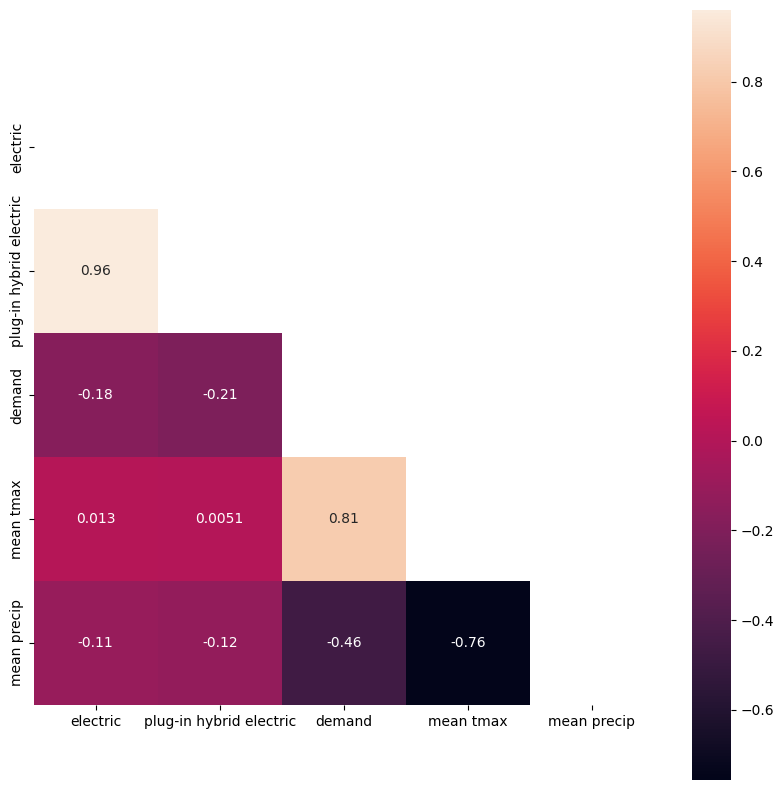

In [172]:
df = df.drop(columns=['date'])

correlation = df.corr(method = 'pearson')
plt.subplots(figsize = (10,10))
masked = np.triu(np.ones_like(correlation, dtype=bool)) 
sns.heatmap(correlation,mask=masked,square = True, annot = True)

**Modeling**

In [188]:
# Random Forest

# EVs, plug-in hybrids, tmax, precip -> electricity demand

# Best parameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 7}

X = df.drop(['demand'], axis=1)
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

distribution = {
       'n_estimators': [2,3,5,10,20,30,50,100,200] ,  
       'max_features': ['log2','sqrt','auto'],
       'max_depth': [3,5,7,9,12] ,
       'min_samples_split': [2,4,6,8,10,15,20,30] ,
       'min_samples_leaf': [1,3,4,6,10,15,17]
}

random_forest = RandomForestRegressor()
rf_model = RandomizedSearchCV(estimator = random_forest, param_distributions = distribution, n_iter = 40)                
rf_model.fit(X_train,  y_train)

print(f'Input: {list(X.columns)}')
print(f'Best parameters: {rf_model.best_params_}')
print(f'model score on training data : {rf_model.score(X_train,  y_train)}')
print(f'model score on testing data: {rf_model.score(X_test, y_test)}')

Input: ['electric', 'plug-in hybrid electric', 'mean tmax', 'mean precip']
Best parameters: {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9}
model score on training data : 0.9510285431277491
model score on testing data: 0.8333411331285252


In [180]:
# Gradient Boosted

# EVs, plug-in hybrids, tmax, precip -> electricity demand

# Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 3}

X = df.drop(['demand'], axis=1)
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

distribution = {
       'n_estimators': [2,3,5,10,20,30,50,100,200] ,  
       'max_features': ['log2','sqrt','auto'],
       'max_depth': [3,5,7,9,12] ,
       'min_samples_split': [2,4,6,8,10,15,20,30] ,
       'min_samples_leaf': [1,3,4,6,10,15,17]
}

grad_boost = GradientBoostingRegressor()
gb_model = RandomizedSearchCV(estimator = grad_boost, param_distributions = distribution, n_iter = 40)                
gb_model.fit(X_train,  y_train)

print(f'Input: {list(X.columns)}')
print(f'Best parameters: {gb_model.best_params_}')
print(f'model score on training data : {gb_model.score(X_train,  y_train)}')
print(f'model score on testing data: {gb_model.score(X_test, y_test)}')

Input: ['electric', 'plug-in hybrid electric', 'mean tmax', 'mean precip']
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 3}
model score on training data : 0.9908604674223589
model score on testing data: 0.8379864653691342


Similarly to in 2_emissions_prediction.ipynb, we decide to use a stacked regressor in order to mitigate the RF issue of being unable to predict outside of the input range

**Stacking**

In [181]:
# Linear regression

X = df.drop(['demand'], axis=1)
y = df['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X,y)

print(f'Training data score: {lin_model.score(X_train,  y_train)}')
print(f'Testing data score: {lin_model.score(X_test, y_test)}')

Training data score: 0.750406278613639
Testing data score: 0.7167111158477519


In [182]:
# Lasso

X = df.drop(['demand'], axis=1)
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

print(f'Training data score: {lasso.score(X_train,  y_train)}')
print(f'Testing data score: {lasso.score(X_test, y_test)}')

Training data score: 0.7648531843785259
Testing data score: 0.5764671033491959


In [161]:
# Stacking linear regressor and Random Forest

estimators = [
    ("Linear Regression", lin_model),
    ("Random Forest", rf_model),
]

lin_rf = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
lin_rf

StackingRegressor(estimators=[('Linear Regression', LinearRegression()),
                              ('Random Forest',
                               RandomizedSearchCV(estimator=RandomForestRegressor(),
                                                  n_iter=40,
                                                  param_distributions={'max_depth': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     12],
                                                                       'max_features': ['log2',
                                                                                        'sqrt',
                                                                                        'auto'],
                                                                       'min_samples_leaf': [1,
                                                                                            3,
                                                                                            4,
                                                                                            6,
                                                                                            10,
                                                                                            15,
                                                                                            17],
                                                                       'min_samples_split': [2,
                                                                                             4,
                                                                                             6,
                                                                                             8,
                                                                                             10,
                                                                                             15,
                                                                                             20,
                                                                                             30],
                                                                       'n_estimators': [2,
                                                                                        3,
                                                                                        5,
                                                                                        10,
                                                                                        20,
                                                                                        30,
                                                                                        50,
                                                                                        100,
                                                                                        200]}))],
                  final_estimator=RidgeCV())

In [162]:
X = df.drop(['demand'], axis=1)
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_rf.fit(X,y)
print(f'Training data score: {lin_rf.score(X_train,  y_train)}')
print(f'Testing data score: {lin_rf.score(X_test, y_test)}')

Training data score: 0.9194366675287334
Testing data score: 0.9269669591604951


In [163]:
# Stacking lasso and Random Forest

estimators = [
    ("Lasso", lasso),
    ("Random Forest", rf_model),
]

lasso_rf = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
lasso_rf

StackingRegressor(estimators=[('Lasso', Lasso()),
                              ('Random Forest',
                               RandomizedSearchCV(estimator=RandomForestRegressor(),
                                                  n_iter=40,
                                                  param_distributions={'max_depth': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     12],
                                                                       'max_features': ['log2',
                                                                                        'sqrt',
                                                                                        'auto'],
                                                                       'min_samples_leaf': [1,
                                                                                            3,
                                                                                            4,
                                                                                            6,
                                                                                            10,
                                                                                            15,
                                                                                            17],
                                                                       'min_samples_split': [2,
                                                                                             4,
                                                                                             6,
                                                                                             8,
                                                                                             10,
                                                                                             15,
                                                                                             20,
                                                                                             30],
                                                                       'n_estimators': [2,
                                                                                        3,
                                                                                        5,
                                                                                        10,
                                                                                        20,
                                                                                        30,
                                                                                        50,
                                                                                        100,
                                                                                        200]}))],
                  final_estimator=RidgeCV())

In [164]:
X = df.drop(['demand'], axis=1)
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lasso_rf.fit(X,y)
print(f'Training data score: {lasso_rf.score(X_train,  y_train)}')
print(f'Testing data score: {lasso_rf.score(X_test, y_test)}')

Training data score: 0.9504986868378809
Testing data score: 0.9517328757267549


In [178]:
# Stacking linear regressor and GB

estimators = [
    ("Linear Regression", lin_model),
    ("Gradient Boosted", gb_model),
]

lin_gb = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
lin_gb

StackingRegressor(estimators=[('Linear Regression', LinearRegression()),
                              ('Gradient Boosted',
                               RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                                                  n_iter=40,
                                                  param_distributions={'max_depth': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     12],
                                                                       'max_features': ['log2',
                                                                                        'sqrt',
                                                                                        'auto'],
                                                                       'min_samples_leaf': [1,
                                                                                            3,
                                                                                            4,
                                                                                            6,
                                                                                            10,
                                                                                            15,
                                                                                            17],
                                                                       'min_samples_split': [2,
                                                                                             4,
                                                                                             6,
                                                                                             8,
                                                                                             10,
                                                                                             15,
                                                                                             20,
                                                                                             30],
                                                                       'n_estimators': [2,
                                                                                        3,
                                                                                        5,
                                                                                        10,
                                                                                        20,
                                                                                        30,
                                                                                        50,
                                                                                        100,
                                                                                        200]}))],
                  final_estimator=RidgeCV())

In [179]:
X = df.drop(['demand'], axis=1)
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_gb.fit(X,y)
print(f'Training data score: {lin_gb.score(X_train,  y_train)}')
print(f'Testing data score: {lin_gb.score(X_test, y_test)}')

Training data score: 0.9776630315608711
Testing data score: 0.9836050653006465


In [176]:
# Stacking lasso and gradient boosting

estimators = [
    ("Lasso", lasso),
    ("Gradient Boosted", gb_model),
]

lasso_gb = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
lasso_gb

StackingRegressor(estimators=[('Lasso', Lasso()),
                              ('Gradient Boosted',
                               RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                                                  n_iter=40,
                                                  param_distributions={'max_depth': [3,
                                                                                     5,
                                                                                     7,
                                                                                     9,
                                                                                     12],
                                                                       'max_features': ['log2',
                                                                                        'sqrt',
                                                                                        'auto'],
                                                                       'min_samples_leaf': [1,
                                                                                            3,
                                                                                            4,
                                                                                            6,
                                                                                            10,
                                                                                            15,
                                                                                            17],
                                                                       'min_samples_split': [2,
                                                                                             4,
                                                                                             6,
                                                                                             8,
                                                                                             10,
                                                                                             15,
                                                                                             20,
                                                                                             30],
                                                                       'n_estimators': [2,
                                                                                        3,
                                                                                        5,
                                                                                        10,
                                                                                        20,
                                                                                        30,
                                                                                        50,
                                                                                        100,
                                                                                        200]}))],
                  final_estimator=RidgeCV())

In [177]:
X = df.drop(['demand'], axis=1)
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lasso_gb.fit(X,y)
print(f'Training data score: {lasso_gb.score(X_train,  y_train)}')
print(f'Testing data score: {lasso_gb.score(X_test, y_test)}')

Training data score: 0.9769482216370424
Testing data score: 0.9586412789432706


Using lasso and Random Forest is more accurate, so we proceed with the lasso_rf stacked regressor

**Example predictions**

In [187]:
# electric, plug-in hybrid electric, tmax, average precipitation
test1 = [[471418,289913,88.951724,0.057241]] # Data from August 2021
test2 = [[4714180,289913,88.951724,0.057241]]

print('1. Values from Aug 2021. Expected demand value: 27525448')
print(f'Using Random Forest alone: {int(rf_model.predict(test1)[0])} MW')
print(f'Using Gradient Boosted alone: {int(gb_model.predict(test1)[0])} MW')
print(f'Using Random Forest and Lasso: {int(lasso_rf.predict(test1)[0])} MW')


print('2. Same values as above with EV numbers increased by a factor of 10')
print(f'Using Random Forest alone: {int(rf_model.predict(test2)[0])} MW')
print(f'Using Gradient Boosted alone: {int(gb_model.predict(test2)[0])} MW')
print(f'Using Random Forest and Lasso: {int(lasso_rf.predict(test2)[0])} MW')


1. Values from Aug 2021. Expected demand value: 27525448
Using Random Forest alone:27434855 MW
Using Gradient Boosted alone: 27724961 MW
Using Random Forest and Lasso: 27375217 MW
2. Same values as above with EV numbers increased by a factor of 10
Using Random Forest alone: 27434855 MW
Using Gradient Boosted alone: 27724961 MW
Using Random Forest and Lasso: 31647935 MW
